<a href="https://colab.research.google.com/github/wjlim-14/payment-card-fraud-detection-keras/blob/main/event_classification_for_payment_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Event classification for payment card fraud detection

**Author:** [achoum](https://github.com/achoum/)<br>
**Date created:** 2024/02/01<br>
**Last modified:** 2024/02/01<br>
**Description:** Detection of fraudulent payment card transactions using Temporian and a feed-forward neural network.

This notebook depends on Keras 3, Temporian, and a few other libraries. You can
install them as follow:

```shell
pip install temporian keras pandas tf-nightly scikit-learn -U
```

In [1]:
!pip install temporian keras pandas tf-nightly scikit-learn -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 639.4/639.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.0/590.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.7/578.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import keras  # To train the Machine Learning model
import temporian as tp  # To convert transactions into tabular data

import numpy as np
import os
import pandas as pd
import datetime
import math
import tensorflow as tf
from sklearn.metrics import RocCurveDisplay

## Introduction

Payment fraud detection is critical for banks, businesses, and consumers. In
Europe alone, fraudulent transactions were estimated at
[€1.89 billion in 2019](https://www.ecb.europa.eu/pub/pdf/cardfraud/ecb.cardfraudreport202110~cac4c418e8.en.pdf).
Worldwide, approximately
[3.6%](https://www.cybersource.com/content/dam/documents/campaign/fraud-report/global-fraud-report-2022.pdf)
of commerce revenue is lost to fraud. In this notebook, we train and evaluate a
model to detect fraudulent transactions using the synthetic dataset attached to
the book
[Reproducible Machine Learning for Credit Card Fraud Detection](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html)
by Le Borgne et al.

Fraudulent transactions often cannot be detected by looking at transactions in
isolation. Instead, fraudulent transactions are detected by looking at patterns
across multiple transactions from the same user, to the same merchant, or with
other types of relationships. To express these relationships in a way that is
understandable by a machine learning model, and to augment features with feature
 engineering, we We use the
 [Temporian](https://temporian.readthedocs.io/en/latest) preprocessing library.

We preprocess a transaction dataset into a tabular dataset and use a
feed-forward neural network to learn the patterns of fraud and make predictions.

## Loading the dataset

The dataset contains payment transactions sampled between April 1, 2018 and
September 30, 2018. The transactions are stored in CSV files, one for each day.

**Note:** Downloading the dataset takes ~1 minute.

In [3]:
start_date = datetime.date(2018, 4, 1)
end_date = datetime.date(2018, 9, 30)

# Load the dataset as a Pandas dataframe.
cache_path = "fraud_detection_cache.csv"
if not os.path.exists(cache_path):
    print("Download dataset")
    dataframes = []
    num_files = (end_date - start_date).days
    counter = 0
    while start_date <= end_date:
        if counter % (num_files // 10) == 0:
            print(f"[{100 * (counter+1) // num_files}%]", end="", flush=True)
        print(".", end="", flush=True)
        url = f"https://github.com/Fraud-Detection-Handbook/simulated-data-raw/raw/6e67dbd0a3bfe0d7ec33abc4bce5f37cd4ff0d6a/data/{start_date}.pkl"
        dataframes.append(pd.read_pickle(url))
        start_date += datetime.timedelta(days=1)
        counter += 1
    print("done", flush=True)
    transactions_dataframe = pd.concat(dataframes)
    transactions_dataframe.to_csv(cache_path, index=False)
else:
    print("Load dataset from cache")
    transactions_dataframe = pd.read_csv(
        cache_path, dtype={"CUSTOMER_ID": bytes, "TERMINAL_ID": bytes}
    )

print(f"Found {len(transactions_dataframe)} transactions")

Download dataset
[0%]..................[10%]..................[20%]..................[30%]..................[40%]..................[50%]..................[59%]..................[69%]..................[79%]..................[89%]..................[99%]...done
Found 1754155 transactions


Each transaction is represented by a single row, with the following columns of
interest:

- **TX_DATETIME**: The date and time of the transaction.
- **CUSTOMER_ID**: The unique identifier of the customer.
- **TERMINAL_ID**: The identifier of the terminal where the transaction was
    made.
- **TX_AMOUNT**: The amount of the transaction.
- **TX_FRAUD**: Whether the transaction is fraudulent (1) or not (0).

In [5]:
transactions_dataframe = transactions_dataframe[
    ["TX_DATETIME", "CUSTOMER_ID", "TERMINAL_ID", "TX_AMOUNT", "TX_FRAUD"]
]

transactions_dataframe.head(4)

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
0,2018-04-01 00:00:31,596,3156,57.16,0
1,2018-04-01 00:02:10,4961,3412,81.51,0
2,2018-04-01 00:07:56,2,1365,146.00,0
3,2018-04-01 00:09:29,4128,8737,64.49,0


The dataset is highly imbalanced, with the majority of transactions being
legitimate.

In [6]:
fraudulent_rate = transactions_dataframe["TX_FRAUD"].mean()
print("Rate of fraudulent transactions:", fraudulent_rate)

Rate of fraudulent transactions: 0.008369271814634397


The
[pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
is converted into a
[Temporian EventSet](https://temporian.readthedocs.io/en/latest/reference/temporian/EventSet/),
which is better suited for the data exploration and feature preprocessing of the
 next steps.

In [7]:
transactions_evset = tp.from_pandas(transactions_dataframe, timestamps="TX_DATETIME")

transactions_evset

timestamp,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
2018-04-01 00:00:31+00:00,596,3156,57.16,0
2018-04-01 00:02:10+00:00,4961,3412,81.51,0
2018-04-01 00:07:56+00:00,2,1365,146,0
2018-04-01 00:09:29+00:00,4128,8737,64.49,0
2018-04-01 00:10:34+00:00,927,9906,50.99,0
…,…,…,…,…


It is possible to plot the entire dataset, but the resulting plot will be
difficult to read. Instead, we can group the transactions per client.

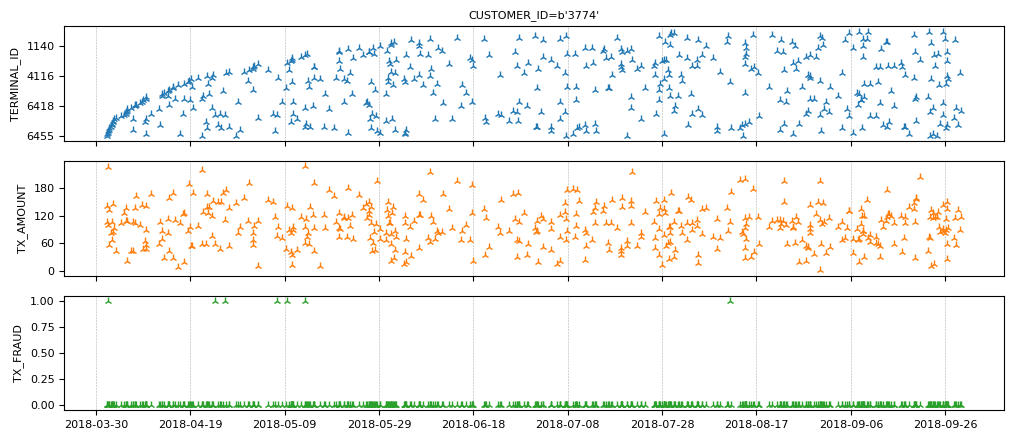

In [8]:
transactions_evset.add_index("CUSTOMER_ID").plot(indexes="3774")

Note the few fraudulent transactions for this client.

## Preparing the training data

Fraudulent transactions in isolation cannot be detected. Instead, we need to
connect related transactions. For each transaction, we compute the sum and count
of transactions for the same terminal in the last `n` days. Because we don't
know the correct value for `n`, we use multiple values for `n` and compute a
set of features for each of them.

In [9]:
# Group the transactions per terminal
transactions_per_terminal = transactions_evset.add_index("TERMINAL_ID")

# Moving statistics per terminal
tmp_features = []
for n in [7, 14, 28]:
    tmp_features.append(
        transactions_per_terminal["TX_AMOUNT"]
        .moving_sum(tp.duration.days(n))
        .rename(f"sum_transactions_{n}_days")
    )

    tmp_features.append(
        transactions_per_terminal.moving_count(tp.duration.days(n)).rename(
            f"count_transactions_{n}_days"
        )
    )

feature_set_1 = tp.glue(*tmp_features)

feature_set_1

timestamp,sum_transactions_7_days,count_transactions_7_days,sum_transactions_14_days,count_transactions_14_days,sum_transactions_28_days,count_transactions_28_days
2018-04-02 01:00:01+00:00,16.07,1,16.07,1,16.07,1
2018-04-02 09:49:55+00:00,83.9,2,83.9,2,83.9,2
2018-04-03 12:14:41+00:00,110.7,3,110.7,3,110.7,3
2018-04-05 16:47:41+00:00,151.2,4,151.2,4,151.2,4
2018-04-07 06:05:21+00:00,199.6,5,199.6,5,199.6,5
…,…,…,…,…,…,…
timestamp,sum_transactions_7_days,count_transactions_7_days,sum_transactions_14_days,count_transactions_14_days,sum_transactions_28_days,count_transactions_28_days
2018-04-01 16:24:39+00:00,70.36,1,70.36,1,70.36,1
2018-04-02 11:25:03+00:00,87.79,2,87.79,2,87.79,2
2018-04-04 08:31:48+00:00,211.6,3,211.6,3,211.6,3


Let's look at the features of terminal "3774".

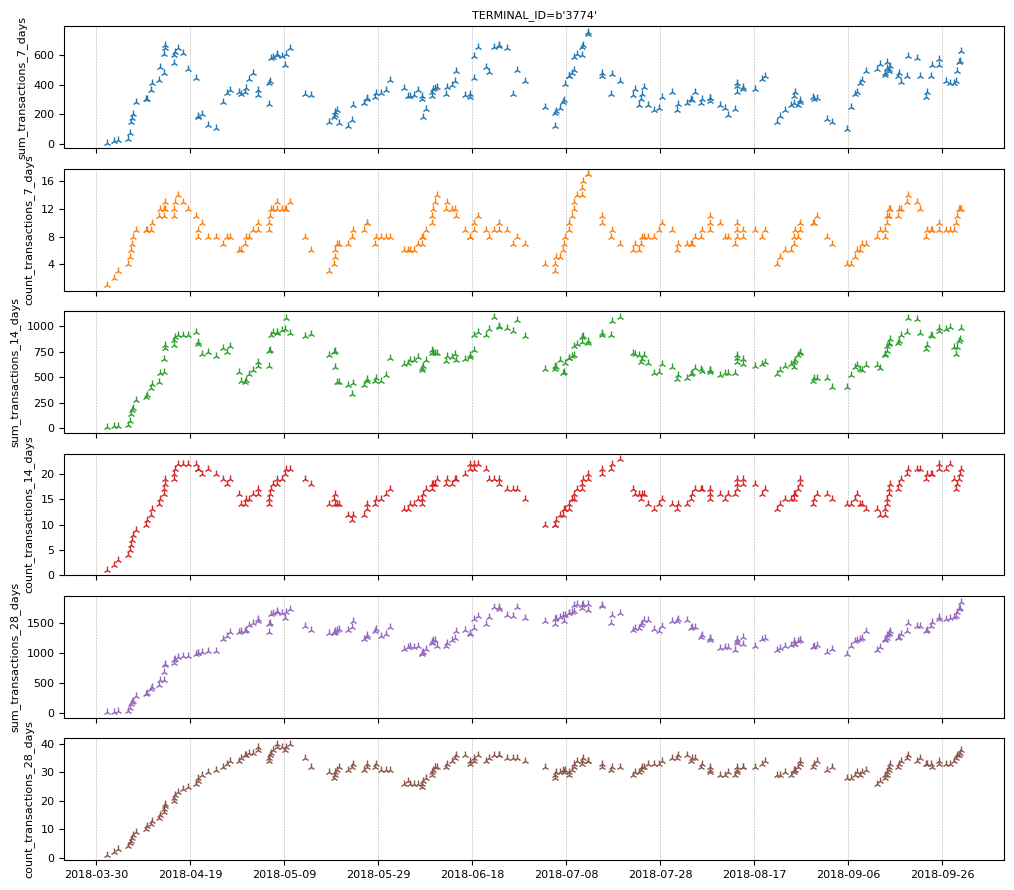

In [10]:
feature_set_1.plot(indexes="3774")

A transaction's fraudulent status is not known at the time of the transaction
(otherwise, there would be no problem). However, the banks knows if a
transacation is fraudulent one week after it is made. We create a set of
features that indicate the number and ratio of fraudulent transactions in the
last N days.

In [11]:
# Lag the transactions by one week.
lagged_transactions = transactions_per_terminal.lag(tp.duration.weeks(1))

# Moving statistics per customer
tmp_features = []
for n in [7, 14, 28]:
    tmp_features.append(
        lagged_transactions["TX_FRAUD"]
        .moving_sum(tp.duration.days(n), sampling=transactions_per_terminal)
        .rename(f"count_fraud_transactions_{n}_days")
    )

    tmp_features.append(
        lagged_transactions["TX_FRAUD"]
        .cast(tp.float32)
        .simple_moving_average(tp.duration.days(n), sampling=transactions_per_terminal)
        .rename(f"rate_fraud_transactions_{n}_days")
    )

feature_set_2 = tp.glue(*tmp_features)

Transaction date and time can be correlated with fraud. While each transaction
has a timestamp, a machine learning model might struggle to consume them
directly. Instead, we extract various informative calendar features from the
timestamps, such as hour, day of the week (e.g., Monday, Tuesday), and day of
the month (1-31).

In [12]:
feature_set_3 = tp.glue(
    transactions_per_terminal.calendar_hour(),
    transactions_per_terminal.calendar_day_of_week(),
)

Finally, we group together all the features and the label.

In [13]:
all_data = tp.glue(
    transactions_per_terminal, feature_set_1, feature_set_2, feature_set_3
).drop_index()

print("All the available features:")
all_data.schema.feature_names()

All the available features:


['CUSTOMER_ID',
 'TX_AMOUNT',
 'TX_FRAUD',
 'sum_transactions_7_days',
 'count_transactions_7_days',
 'sum_transactions_14_days',
 'count_transactions_14_days',
 'sum_transactions_28_days',
 'count_transactions_28_days',
 'count_fraud_transactions_7_days',
 'rate_fraud_transactions_7_days',
 'count_fraud_transactions_14_days',
 'rate_fraud_transactions_14_days',
 'count_fraud_transactions_28_days',
 'rate_fraud_transactions_28_days',
 'calendar_hour',
 'calendar_day_of_week',
 'TERMINAL_ID']

We extract the name of the input features.

In [14]:
input_feature_names = [k for k in all_data.schema.feature_names() if k.islower()]

print("The model's input features:")
input_feature_names

The model's input features:


['sum_transactions_7_days',
 'count_transactions_7_days',
 'sum_transactions_14_days',
 'count_transactions_14_days',
 'sum_transactions_28_days',
 'count_transactions_28_days',
 'count_fraud_transactions_7_days',
 'rate_fraud_transactions_7_days',
 'count_fraud_transactions_14_days',
 'rate_fraud_transactions_14_days',
 'count_fraud_transactions_28_days',
 'rate_fraud_transactions_28_days',
 'calendar_hour',
 'calendar_day_of_week']

For neural networks to work correctly, numerical inputs must be normalized. A
common approach is to apply z-normalization, which involves subtracting the mean
and dividing by the standard deviation estimated from the training data to each
value. In forecasting, such z-normalization is not recommended as it would lead
to future leakage. Specifically, to classify a transaction at time t, we cannot
rely on data after time t since, at serving time when making a prediction at
time t, no subsequent data is available yet. In short, at time t, we are limited
to using data that precedes or is concurrent with time t.

The solution is therefore to apply z-normalization **over time**, which means
that we normalize each transaction using the mean and standard deviation
computed from the past data **for that transaction**.

Future leakage is pernicious. Luckily, Temporian is here to help: the only
operator that can cause future leakage is `EventSet.leak()`. If you are not
using `EventSet.leak()`, your preprocessing is **guaranteed** not to create
future leakage.

**Note:** For advanced pipelines, you can also check programatically that a
feature does not depends on an `EventSet.leak()` operation.

In [15]:
# Cast all values (e.g. ints) to floats.
values = all_data[input_feature_names].cast(tp.float32)

# Apply z-normalization overtime.
normalized_features = (
    values - values.simple_moving_average(math.inf)
) / values.moving_standard_deviation(math.inf)

# Restore the original name of the features.
normalized_features = normalized_features.rename(values.schema.feature_names())

print(normalized_features)

indexes: []
features: [('sum_transactions_7_days', float32), ('count_transactions_7_days', float32), ('sum_transactions_14_days', float32), ('count_transactions_14_days', float32), ('sum_transactions_28_days', float32), ('count_transactions_28_days', float32), ('count_fraud_transactions_7_days', float32), ('rate_fraud_transactions_7_days', float32), ('count_fraud_transactions_14_days', float32), ('rate_fraud_transactions_14_days', float32), ('count_fraud_transactions_28_days', float32), ('rate_fraud_transactions_28_days', float32), ('calendar_hour', float32), ('calendar_day_of_week', float32)]
events:
     (1754155 events):
        timestamps: ['2018-04-01T00:00:31' '2018-04-01T00:02:10' '2018-04-01T00:07:56' ...
     '2018-09-30T23:58:21' '2018-09-30T23:59:52' '2018-09-30T23:59:57']
        'sum_transactions_7_days': [ 0.      1.      1.3636 ... -0.064  -0.2059  0.8428]
        'count_transactions_7_days': [   nan    nan    nan ... 1.0128 0.6892 1.66  ]
        'sum_transactions_14_da

/usr/local/lib/python3.10/dist-packages/temporian/implementation/numpy/operators/binary/arithmetic.py:100: RuntimeWarning: invalid value encountered in divide
  return evset_1_feature / evset_2_feature


The first transactions will be normalized using poor estimates of the mean and
standard deviation since there are only a few transactions before them. To
mitigate this issue, we remove the first week of data from the training dataset.

Notice that the first values contain NaN. In Temporian, NaN represents missing
values, and all operators handle them accordingly. For instance, when
calculating a moving average, NaN values are not included in the calculation
and do not generate a NaN result.

However, neural networks cannot natively handle NaN values. So, we replace them
with zeros.

In [16]:
normalized_features = normalized_features.fillna(0.0)

Finally, we group together the features and the labels.

In [17]:
normalized_all_data = tp.glue(normalized_features, all_data["TX_FRAUD"])

## Split dataset into a train, validation and test set

To evaluate the quality of our machine learning model, we need training,
validation and test sets. Since the system is dynamic (new fraud patterns are
being created all the time), it is important for the training set to come before
the validation set, and the validation set come before the testing set:

- **Training:** April 8, 2018 to July 31, 2018
- **Validation:** August 1, 2018 to August 31, 2018
- **Testing:** September 1, 2018 to September 30, 2018

For the example to run faster, we will effectively reduce the size of the
training set to:
- **Training:** July 1, 2018 to July 31, 2018

In [18]:
# begin_train = datetime.datetime(2018, 4, 8).timestamp() # Full training dataset
begin_train = datetime.datetime(2018, 7, 1).timestamp()  # Reduced training dataset
begin_valid = datetime.datetime(2018, 8, 1).timestamp()
begin_test = datetime.datetime(2018, 9, 1).timestamp()

is_train = (normalized_all_data.timestamps() >= begin_train) & (
    normalized_all_data.timestamps() < begin_valid
)
is_valid = (normalized_all_data.timestamps() >= begin_valid) & (
    normalized_all_data.timestamps() < begin_test
)
is_test = normalized_all_data.timestamps() >= begin_test

`is_train`, `is_valid` and `is_test` are boolean features overtime that indicate
the limit of the tree folds. Let's plot them.

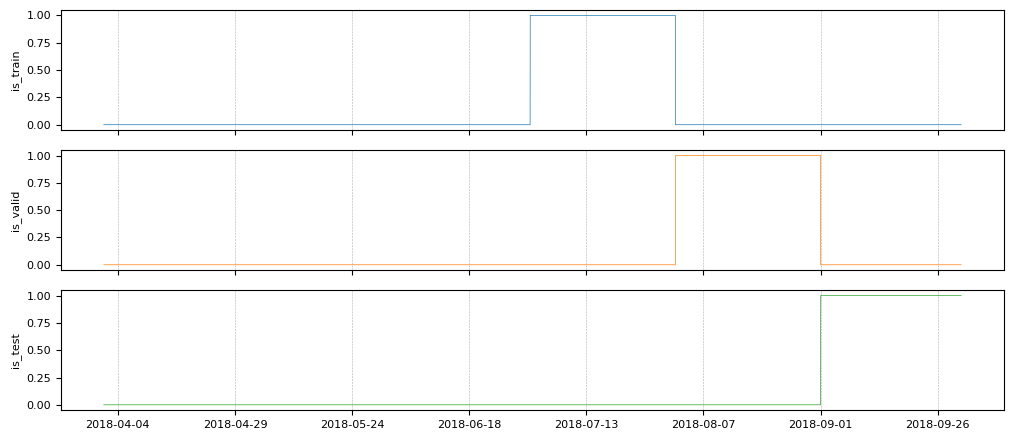

In [19]:
tp.plot(
    [
        is_train.rename("is_train"),
        is_valid.rename("is_valid"),
        is_test.rename("is_test"),
    ]
)

We filter the input features and label in each fold.

In [20]:
train_ds_evset = normalized_all_data.filter(is_train)
valid_ds_evset = normalized_all_data.filter(is_valid)
test_ds_evset = normalized_all_data.filter(is_test)

print(f"Training examples: {train_ds_evset.num_events()}")
print(f"Validation examples: {valid_ds_evset.num_events()}")
print(f"Testing examples: {test_ds_evset.num_events()}")

Training examples: 296928
Validation examples: 296559
Testing examples: 287873


It is important to split the dataset **after** the features have been computed
because some of the features for the training dataset are computed from
transactions during the training window.

## Create TensorFlow datasets

We convert the datasets from EventSets to TensorFlow Datasets as Keras consumes
them natively.

In [21]:
non_batched_train_ds = tp.to_tensorflow_dataset(train_ds_evset)
non_batched_valid_ds = tp.to_tensorflow_dataset(valid_ds_evset)
non_batched_test_ds = tp.to_tensorflow_dataset(test_ds_evset)

The following processing steps are applied using TensorFlow datasets:

1. The features and labels are separated using `extract_features_and_label` in
    the format that Keras expects.
1. The dataset is batched, which means that the examples are grouped into
    mini-batches.
1. The training examples are shuffled to improve the quality of mini-batch
    training.

As we noted before, the dataset is imbalanced in the direction of legitimate
transactions. While we want to evaluate our model on this original distribution,
neural networks often train poorly on strongly imbalanced datasets. Therefore,
we resample the training dataset to a ratio of 80% legitimate / 20% fraudulent
using `rejection_resample`.

In [22]:

def extract_features_and_label(example):
    features = {k: example[k] for k in input_feature_names}
    labels = tf.cast(example["TX_FRAUD"], tf.int32)
    return features, labels


# Target ratio of fraudulent transactions in the training dataset.
target_rate = 0.2

# Number of examples in a mini-batch.
batch_size = 32

train_ds = (
    non_batched_train_ds.shuffle(10000)
    .rejection_resample(
        class_func=lambda x: tf.cast(x["TX_FRAUD"], tf.int32),
        target_dist=[1 - target_rate, target_rate],
        initial_dist=[1 - fraudulent_rate, fraudulent_rate],
    )
    .map(lambda _, x: x)  # Remove the label copy added by "rejection_resample".
    .batch(batch_size)
    .map(extract_features_and_label)
    .prefetch(tf.data.AUTOTUNE)
)

# The test and validation dataset does not need resampling or shuffling.
valid_ds = (
    non_batched_valid_ds.batch(batch_size)
    .map(extract_features_and_label)
    .prefetch(tf.data.AUTOTUNE)
)
test_ds = (
    non_batched_test_ds.batch(batch_size)
    .map(extract_features_and_label)
    .prefetch(tf.data.AUTOTUNE)
)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



We print the first four examples of the training dataset. This is a simple way
to identify some of the errors that could have been made above.

In [23]:
for features, labels in train_ds.take(1):
    print("features")
    for feature_name, feature_value in features.items():
        print(f"\t{feature_name}: {feature_value[:4]}")
    print(f"labels: {labels[:4]}")

features
	sum_transactions_7_days: [-0.7190561 -1.4646987  0.2021024  1.5533459]
	count_transactions_7_days: [-0.8704386  -0.87053746  0.08350954  0.40198445]
	sum_transactions_14_days: [ 0.38741   -1.3418838  0.5546208  0.8980732]
	count_transactions_14_days: [ 0.00980672 -0.9144425   0.37931022  0.19535133]
	sum_transactions_28_days: [-0.2492948  -0.58537054  0.59071517  1.1216327 ]
	count_transactions_28_days: [-0.26051825  0.21190506  0.30655986  0.8752295 ]
	count_fraud_transactions_7_days: [-0.09785811 -0.09788197 -0.09787574 -0.09778524]
	rate_fraud_transactions_7_days: [-0.10955629 -0.10958406 -0.10957736 -0.10947693]
	count_fraud_transactions_14_days: [-0.10455424 -0.10457057 -0.10457042 -0.10446825]
	rate_fraud_transactions_14_days: [-0.11569533 -0.1157095  -0.11571071 -0.11562261]
	count_fraud_transactions_28_days: [-0.1130055  -0.11301769 -0.11301756 -0.11285781]
	rate_fraud_transactions_28_days: [-0.12643485 -0.12644039 -0.1264404  -0.12632528]
	calendar_hour: [1.092365   

## Train the model

The original dataset is transactional, but the processed data is tabular and
only contains normalized numerical values. Therefore, we train a feed-forward
neural network.

In [24]:
inputs = [keras.Input(shape=(1,), name=name) for name in input_feature_names]
x = keras.layers.concatenate(inputs)
x = keras.layers.Dense(32, activation="sigmoid")(x)
x = keras.layers.Dense(16, activation="sigmoid")(x)
x = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=x)

Our goal is to differentiate between the fraudulent and legitimate transactions,
so we use a binary classification objective. Because the dataset is imbalanced,
accuracy is not an informative metric. Instead, we evaluate the model using the
[area under the curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)
(AUC).

In [25]:
model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.Accuracy(), keras.metrics.AUC()],
)
model.fit(train_ds, validation_data=valid_ds)

    423/Unknown 43s 94ms/step - accuracy: 0.0000e+00 - auc: 0.8177 - loss: 0.3530

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


423/423 ━━━━━━━━━━━━━━━━━━━━ 64s 144ms/step - accuracy: 0.0000e+00 - auc: 0.8178 - loss: 0.3529 - val_accuracy: 0.0000e+00 - val_auc: 0.8269 - val_loss: 0.1607


We evaluate the model on the test dataset.

In [26]:
model.evaluate(test_ds)

8997/8997 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.0000e+00 - auc: 0.8360 - loss: 0.1630


[0.1632664054632187, 0.0, 0.8272995352745056]

With and AUC of ~83%, our simple fraud detector is showing encouraging
results.


Plotting the ROC curve is a good solution to understand and select the operation
point of the model i.e. the threshold applied on the model output to
differentiate between fraudulent and legitimate transactions.

Compute the test predictions:

In [27]:
predictions = model.predict(test_ds)
predictions = np.nan_to_num(predictions, nan=0)

8997/8997 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


Extract the labels from the test set:

In [28]:
labels = np.concatenate([label for _, label in test_ds])

Finaly, we plot the ROC curve.

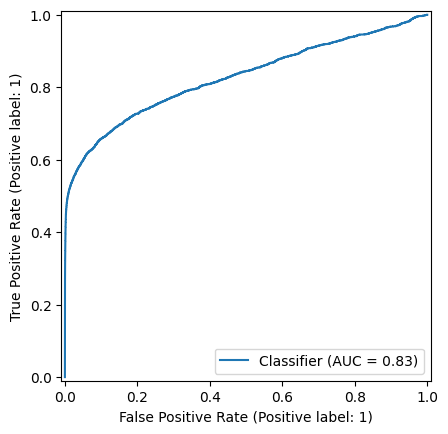

In [29]:
_ = RocCurveDisplay.from_predictions(labels, predictions)


The Keras model is ready to be used on transactions with an unknown fraud
status, a.k.a. serving. We save the model on disk for future use.

**Note:** The model does not include the data preparation and preprocessing steps
done in Pandas and Temporian. They have to be applied manually to the data fed
into the model. While not demonstrated here, Temporian preprocessing can also be
saved to disk with
[tp.save](https://temporian.readthedocs.io/en/latest/reference/temporian/serialization/save/).

In [30]:
model.save("fraud_detection_model.keras")

The model can be later reloaded with:

In [31]:
loaded_model = keras.saving.load_model("fraud_detection_model.keras")

# Generate predictions with the loaded model on 5 test examples.
loaded_model.predict(test_ds.rebatch(5).take(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


array([[0.1532897 ],
       [0.07252048],
       [0.38823414],
       [0.05947975],
       [0.08502957]], dtype=float32)

## Conclusion

We trained a feed-forward neural network to identify fraudulent transactions. To
feed them into the model, the transactions were preprocessed and transformed
into a tabular dataset using
[Temporian](https://temporian.readthedocs.io/en/latest/). Now, a question to the
reader: What could be done to further improve the model's performance?

Here are some ideas:

- Train the model on the entire dataset instead of a single month of data.
- Train the model for more epochs and use early stopping to ensure that the
    model is fully trained without overfitting.
- Make the feed-forward network more powerful by increasing the number of layers
    while ensuring that the model is regularized.
- Compute additional preprocessing features. For example, in addition to
    aggregating transactions by terminal, aggregate transactions by client.
- Use the Keras Tuner to perform hyperparameter tuning on the model. Note that
    the parameters of the preprocessing (e.g., the number of days of
    aggregations) are also hyperparameters that can be tuned.